* Student Name: Daniel Mwaka
* Student Pace: DSF-FT12-Hybrid
* Instructor Name: Samuel Karu

# Box Office Performance Analysis for New Movie Studio

## Introduction 

The ever-increasing adoption and embracement of internet-hosted, media-sharing platforms exposes audiences to a diverse, highly-dense entertainment alternatives. This claim is justified by the rising number of companies entering the video streaming sector. Additionally, long-video content is increasingly facing stiff competition from social media and video-hosting platforms such as Youtube. Although venturing into the movie production sector is a potentially profitable portfolio diversification strategy; data-driven decision making is vital in orienting the company to conform with market trends and meet target audience expectations.

## Problem Statement

The company plans to diversify its portfolio by launching a new division for movie production. Designing, implementing, sourcing talent, and operational expenses for running a new studio is a costly endevour. To ensure that the produces profitable movies, the company seeks data-driven insights to support appropriate corporate decisions.

## Objectives

<strong> 1: </strong> To determine factors that have a statistically significant relationship to a movie's total grossing. 

<strong> 2: </strong> To determine which movie genres have the highest grossing films

<strong> 3: </strong> To identify key potential collaborators based on the cumulative grossing of a studio's movies.

## Data Understanding

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
%matplotlib inline


* Loading and cleaning the bom.movie.movie_gross.csv dataset

In [2]:
# Load the data from the .csv file as a DataFrame and display first five rows
movie_gross_data = pd.read_csv('../zipped-data/bom.movie_gross.csv')
movie_gross_data.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
# Check the DataFrame's shape
movie_gross_data.shape
print(f"DataFrame consists of {movie_gross_data.shape[0]} rows")
print(f"DataFrame consists of {movie_gross_data.shape[1]} columns")

DataFrame consists of 3387 rows
DataFrame consists of 5 columns


In [4]:
# Check column attributes
movie_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


There are multiple rows entries with missing data values for the `studio`, `domestic_gross`, and `foreign_gross` columns.  

In [5]:
# Create a copy of the data DataFrame to perform data cleaning
gross_dataset = movie_gross_data.copy()

In [6]:
# Drop row entries with missing values for the 'studio', `domestic_gross`, and `foreign_gross` column
gross_dataset = gross_dataset.dropna(subset=['studio'])
gross_dataset = gross_dataset.dropna(subset=['domestic_gross'])
gross_dataset = gross_dataset.dropna(subset=['foreign_gross'])


In [7]:
# convert the foreign_gross from object to float64

# Remove commas
gross_dataset['foreign_gross'] = gross_dataset['foreign_gross'].astype(str).str.replace(',', '') 

# Convert to float datatype
gross_dataset['foreign_gross'] = pd.to_numeric(gross_dataset['foreign_gross'], errors='coerce')  

In [8]:
# Confirm columns attributes
gross_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   year            2007 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 94.1+ KB


* Connecting the im.db dataset, loading and cleaning the `movie_basics` table.

In [9]:
# Create a connection to DataBase
conn = sqlite3.connect('../zipped-data/im.db')

In [10]:
# Load data from the movie_basics table
imdb_basics = pd.read_sql("SELECT * FROM movie_basics", conn)
imdb_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [11]:
imdb_basics.shape
print(f"DataFrame consists of {imdb_basics.shape[0]} rows")
print(f"DataFrame consists of {imdb_basics.shape[1]} columns")

DataFrame consists of 146144 rows
DataFrame consists of 6 columns


In [12]:
# Check column attributes
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [13]:
# Create a copy of the data DataFrame to perform data cleaning
imdb_basics_cleaned = imdb_basics.copy()

Dropping the `original_title` since they are redundant to the `primary_title` and for entries they are not; they are the translated version of movie titles from English to other languages. 

In [14]:
imdb_basics_cleaned = imdb_basics_cleaned.drop(columns=['original_title']) 

In [15]:
# Drop row entries with missing values for the primary_title, genres, and runtime_minutes columns
imdb_basics_cleaned = imdb_basics_cleaned.dropna(subset=['primary_title'])
imdb_basics_cleaned = imdb_basics_cleaned.dropna(subset=['genres'])
imdb_basics_cleaned = imdb_basics_cleaned.dropna(subset=['runtime_minutes'])

In [16]:
# Compute descriptive statistics for the runtime_minutes column
imdb_basics_cleaned.describe()

,start_year,runtime_minutes
count,112233.000000,112233.000000
mean,2014.402101,86.261902
std,2.639042,167.895938
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2014.000000,87.000000
75%,2017.000000,99.000000
max,2022.000000,51420.000000


Movies typically never exceed three hours. So the 51420 runtime_minute entry alludes the possiblity of outliers in the dataset.

In [17]:
# Drop all entries with a runtime exceeding three hours by 20 minutes or more
imdb_basics_cleaned = imdb_basics_cleaned[imdb_basics_cleaned['runtime_minutes'] <= 200]

In [18]:
# Check shape after cleaning
imdb_basics_cleaned.shape
print(f"DataFrame consists of {imdb_basics_cleaned.shape[0]} rows")
print(f"DataFrame consists of {imdb_basics_cleaned.shape[1]} columns")

DataFrame consists of 111867 rows
DataFrame consists of 5 columns


In [19]:
# Confirm columns attributes
imdb_basics_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111867 entries, 0 to 146139
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         111867 non-null  object 
 1   primary_title    111867 non-null  object 
 2   start_year       111867 non-null  int64  
 3   runtime_minutes  111867 non-null  float64
 4   genres           111867 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.1+ MB


* Loading and cleaning the movie_ratings table

In [20]:
# Load data from the movie_ratings table
imdb_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)
imdb_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [21]:
# check shape of the imdb_ratings DataFrame
imdb_ratings.shape
print(f"DataFrame consists of {imdb_ratings.shape[0]} rows")
print(f"DataFrame consists of {imdb_ratings.shape[1]} columns")

DataFrame consists of 73856 rows
DataFrame consists of 3 columns


In [22]:
# Check column attributes
imdb_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


The imdb_ratings Dataframe neither has missing values nor duplicates and does not require data cleaning.

### Merging the three DataFrames

Perform an inner join on the imdb_basics_cleaned and the imdb_ratings DataFrames. An inner join returns only the rows with matching keys (movie_id) in both DataFrames. The left join is inappropriate since it would lead to NaNs for row entries of the right DataFrame (imdb_ratings) that don't have a matching movie_id key. 

In [23]:
# Inner Join
imdb_dataset = pd.merge(imdb_basics_cleaned, imdb_ratings, on='movie_id', how='inner')
print("Inner Join:")
imdb_dataset.head()

Inner Join:


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
4,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263


In [24]:
imdb_dataset.shape

(65563, 7)

Modify the name of the `primary_title` column name to `title` to become a matching key in both the imdb_dataset and gross_dataset DataFrames. Creating a matching key allows for the merging of the DataFrames via an inner join. 

In [25]:
# Modifying the name of the column name primary_title to title
imdb_dataset = imdb_dataset.rename(columns={'primary_title': 'title'})

In [26]:
# Confirm column attributes and verify no null values
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65563 entries, 0 to 65562
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65563 non-null  object 
 1   title            65563 non-null  object 
 2   start_year       65563 non-null  int64  
 3   runtime_minutes  65563 non-null  float64
 4   genres           65563 non-null  object 
 5   averagerating    65563 non-null  float64
 6   numvotes         65563 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 4.0+ MB


Merge the imdb_dataset to the gross_dataset on the title matching key using an inner join

In [27]:
# Using an inner join to merge 
df = pd.merge(imdb_dataset, gross_dataset, on='title', how='inner')
print("Inner Join:")
df.head()

Inner Join:


,movie_id,title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,domestic_gross,foreign_gross,year
0,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,IFC,744000.0,8000000.0,2012
1,tt4339118,On the Road,2014,89.0,Drama,6.0,6,IFC,744000.0,8000000.0,2012
2,tt5647250,On the Road,2016,121.0,Drama,5.7,127,IFC,744000.0,8000000.0,2012
3,tt0359950,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,Fox,58200000.0,129900000.0,2013
4,tt0365907,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,Uni.,26300000.0,26900000.0,2014


In [28]:
# Create a copy of the df DataFrame and check shape
df_clean = df.copy()
df_clean.shape

(1766, 11)

The `title` column in the merged DataFrame indicates possibility of duplicates. Define a function to check and drop duplicate entries based on a movie's `title`, `studio`, `domestic_gross`, `foreign_gross`, and `year`

In [29]:
def drop_duplicate_entries(df):
    """
    Define function to drop duplicate entries based on:
    - Marching title
    - Produced by studio
    - Same domestic_gross
    - Same foreign_gross
    - Produced same year
    """
    columns_to_check = ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']
    duplicate_removed = df.drop_duplicates(subset=columns_to_check, keep='first')
    return duplicate_removed

# Call the drop_duplicate function and pass in df_clean as the argument
df_clean = drop_duplicate_entries(df_clean)

In [30]:
# Create a new column for total_grossing
df_clean['total_grossing'] = df_clean['domestic_gross'] + df_clean['foreign_gross']

In [31]:
# Confirm column attributes and verify there are no null values
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 0 to 1765
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         1540 non-null   object 
 1   title            1540 non-null   object 
 2   start_year       1540 non-null   int64  
 3   runtime_minutes  1540 non-null   float64
 4   genres           1540 non-null   object 
 5   averagerating    1540 non-null   float64
 6   numvotes         1540 non-null   int64  
 7   studio           1540 non-null   object 
 8   domestic_gross   1540 non-null   float64
 9   foreign_gross    1540 non-null   float64
 10  year             1540 non-null   int64  
 11  total_grossing   1540 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 156.4+ KB


## Data Analysis and Visualizations

### t-test

Conduct a t-test to compare the averages of `domestic_gross` to `foreign_gross` to determine whether or not the differences could have happened by chance.

In [32]:
# Assign variables for the z-test
domestic_gross = df_clean['domestic_gross']
foreign_gross = df_clean['foreign_gross']

# Calculate the means
mean_domestic = np.mean(domestic_gross)
mean_foreign = np.mean(foreign_gross)

# Calculate the standard deviations
std_domestic = np.std(domestic_gross, ddof=1)  # ddof=1 for sample standard deviation
std_foreign = np.std(foreign_gross, ddof=1)

# Calculate the sample sizes
n_domestic = len(domestic_gross)
n_foreign = len(foreign_gross)

# Compute 
t_statistic, p_value = stats.ttest_ind(domestic_gross, foreign_gross, equal_var=False)
t_statistic, p_value

(-7.418739403877952, 1.6194650726377596e-13)

* Since the p-value (1.6e-13) is less than alpha; the difference between the domestic grossing and foreign grossing is statistically significant and could not have happened by chance. 

Thus, it is crucial to evaluate potential predictor variables for a movie's grossing on the Box Office. 

### ANOVA

ANOVA is deemed the appropriate statistical test for evaluating several variables whether they are potential predictor factors/ have a significant influence on the dependent variable. In this case; the target variable is the total grossing of a film. The predictor factors to be examined include: `genre`, `runtime_minutes`, and `averagerating`.

**One-way ANOVA**

People have unique movie genre preferences; this variable is a potential predictor factor for the total grossing of a film. 
Genre preference is also influenced by pop culture. For instance, the peak period of the <strong> Breaking Bad </strong> series franchise in the early 2010s triggered a spike in the viewership for Crime genre films. However, the validity of a potential statistically significant relationship between genre and movie grossing must be substantiated with empirical evidence to support data-driven corporate decisions. 

* <Strong> Null Hypothesis: </Strong> A movie's genre doesn't have an impact on total grossing.

* <Strong> Alternative Hypothesis: </Strong> A movie's genre has a significant influence on total grossing. 

* <strong> Significance level (alpha) = </strong> 0.05



In [33]:
# 0ne-way ANOVA test (Predictor variable is genre)
formula = 'total_grossing ~ C(genres)'
model = ols(formula, data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(genres),238.0,3.357153e+19,1.410568e+17,5.088679,3.436975e-82
Residual,1301.0,3.606337e+19,2.771973e+16,NaN,NaN


* Reject the Null Hypothesis because the p-value for the categorical variable (genres) is less than alpha (0.05). Hence, a movie's genre has a statistically significant influence on total grossing. 

This finding necessiates a visualization on the best performing genres on the basis of total grossing.

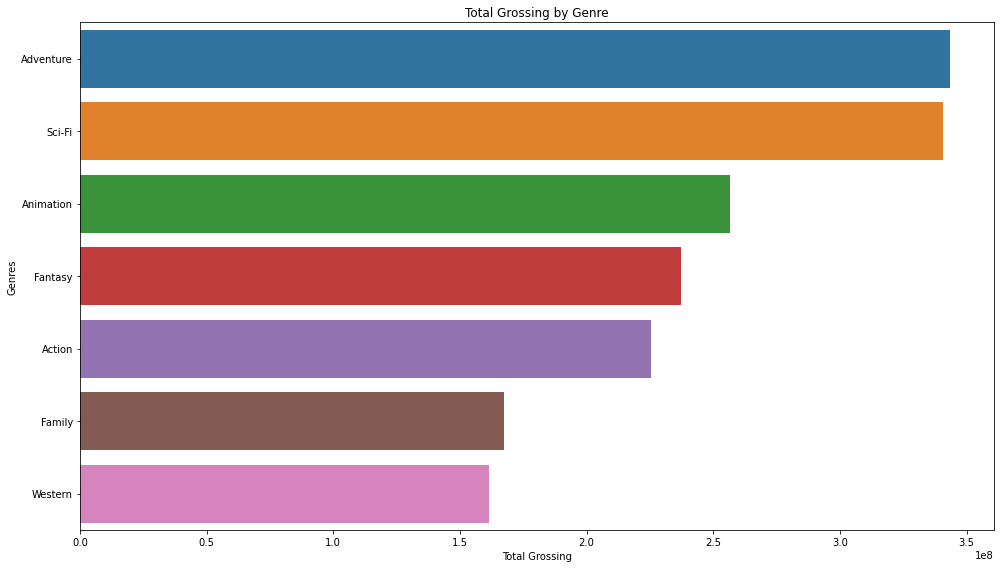

In [60]:
# Define a function to randomly select a genre from a string value. eg (Action, Crime, Drama)
# Randomly selecting one genre from the string mitigates selection bias 

df_clean_modified = df_clean.copy()

def extract_random_genre(genre_str):
    if isinstance(genre_str, str):  # Check if it's a string
        genres = [genre.strip() for genre in genre_str.split(',')]
        if genres:
            return random.choice(genres)
        else:
            return np.nan  # Return NaN if the list of genres is empty
    else:
        return np.nan  # Or some other appropriate missing value representation

df_clean_modified['genres'] = df_clean_modified['genres'].apply(extract_random_genre)

# Visualize total grossing distribution for different movie genres 

# groupby genre and total grossing
genre_gross = df_clean_modified.groupby('genres')['total_grossing'].mean().sort_values(ascending=False).head(7)

# Set plot size, type, title, xlabel, and ylabel
plt.figure(figsize=(14, 8))
sns.barplot(x=genre_gross.values, y=genre_gross.index, orient='h')
plt.title('Total Grossing by Genre')
plt.xlabel('Total Grossing')
plt.ylabel('Genres')
plt.tight_layout()
plt.show()

The **extract_random_genre** function is called to randomly select a genre from the string value of each row in df_clean. For example; an entry with the string value (Action, Crime, Drama) for the `genres` column, the **extract_random_genre** can randomly select the movie's genre as Action, Crime or Drama. Since the selected genre is randomly selected; the code cell above was run for five iterations and the results for the top-7 genres based on `total-grossing` were as follows:

**1st run:** Sci-Fi, Adventure, Animation, Fantasy, Action, Family, Comedy.

**2nd run:** Adventure, Sci-Fi, Animation, Musical, Action, Fantasy, Family.

**3rd run:** Adventure, Sci-Fi, Animation, Action, Fantasy, Family, Thriller.

**4th run:** Sci-Fi, Adventure, Animation, Fantasy, Action, Musical, Family.

**5th run:** Adventure, Sci-Fi, Animation, Fantasy, Action, Family, Western. 

* Based on these results after running five iterations: Adventure, Action, Animation, Fantasy, and Sci-Fi consistendly appeared among top-7 highest grossing movies. Hence, movies featuring at least one of these genres were proven to be among the highest grossing movies in the Box Office.

**Two-way ANOVA**

A movie's runtime is also a potential predictor factor on a film's total grossing. For instance, excessively long movies can easily become boring to viewers and film critics especially during the premiere week. Negative perceptions from the audience and criticisms voiced by film critics across platforms such as rottentomato.com can have a substantial impact on a movie's total grossing in the long-run. Consequently, films with a relatively higher average rating are likelier to outperform their counterparts in the demand for theater tickets and viewership numbers across streaming platforms such as Netflix. Thus, the validity of a statistically significant influence of `runtime_minutes` and `averagerating` on `total_grossing` must be substantiated quantitatively.      

* <Strong> Null Hypothesis: </Strong> A movie's runtime minutes, and average rating don't have an impact on total grossing.

* <Strong> Alternative Hypothesis: </Strong> A movie's runtime, and average rating have a significant influence on total grossing. 

* <strong> Significance level (alpha) = </strong> 0.05

In [51]:
# To access whether `runtime_minutes` has a significant impact on `total_grossing` irrespective of `averagerating`
# To access whether `averagerating` has a significant impact on `total_grossing`irrespective of `runtime_minutes`
formula = 'total_grossing ~ runtime_minutes * averagerating'
model = ols(formula, data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
runtime_minutes,3.102694e+18,1.0,75.393702,9.674097e-18
averagerating,1.002133e+18,1.0,24.351256,8.900560e-07
runtime_minutes:averagerating,8.999968e+17,1.0,21.869413,3.174432e-06
Residual,6.321135e+19,1536.0,NaN,NaN


* Reject the Null Hypothesis because the p-values for `runtime_minutes` (9.7e-18), and `averagerating` (8.9e-7) are less than alpha (0.05). Hence, a movie's runtime, and average rating have a statistically significant influence on total grossing.

* The p-value for **runtime_minutes:averagerating** (3.2e-6) is less than alpha (0.05) which indicates that the effect of `runtime_minutes` on `total_grossing` depends on `averagerating` and vice-versa. To comprehend the nature of this interaction; it is vital to plot histograms for both variables against total grossing.

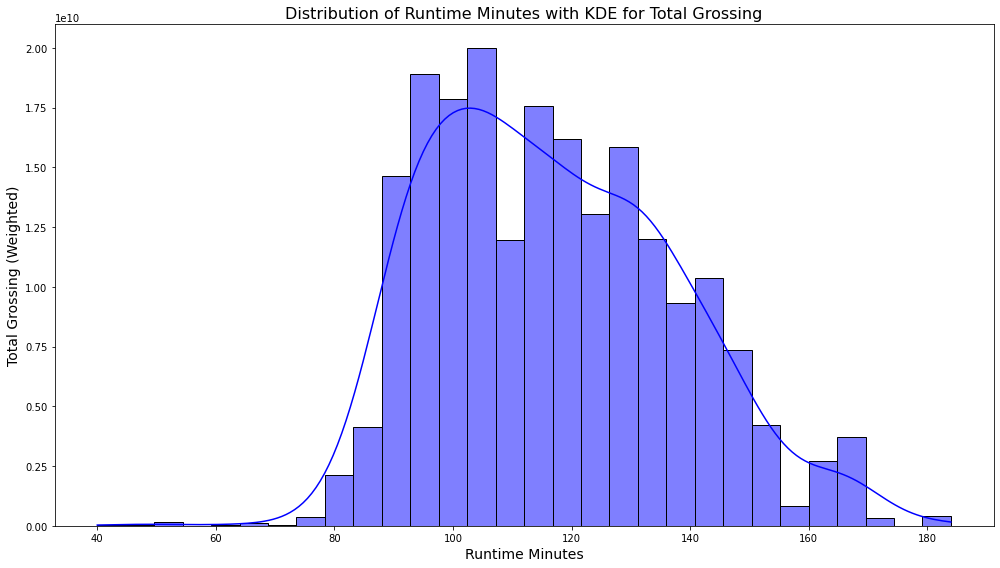

In [54]:
# Visualize distribution of runtime minutes against total grossing

# Set plot size, type, title, xlabel, and ylabel
plt.figure(figsize=(14, 8))
sns.histplot(data=df_clean, x='runtime_minutes', weights='total_grossing', kde=True, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Runtime Minutes with KDE for Total Grossing', fontsize=16)
plt.xlabel('Runtime Minutes', fontsize=14)
plt.ylabel('Total Grossing (Weighted)', fontsize=14)
plt.tight_layout()
plt.show()

* Movies with a runtime between 90 minutes and 130 minutes have the highest grossing in the Box Office

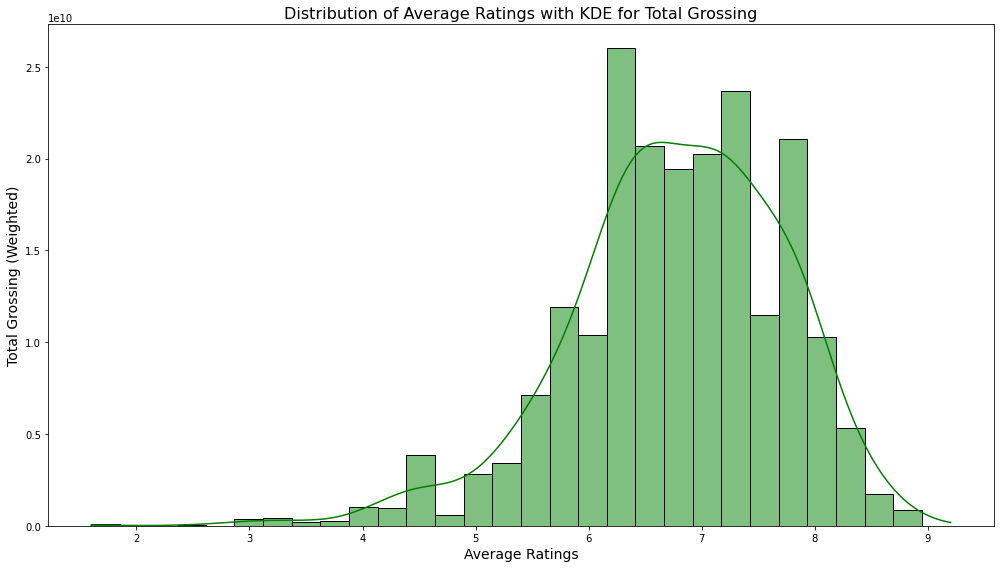

In [55]:
# Visualize distribution of average ratings against total grossing

# Set plot size, type, title, xlabel, and ylabel
plt.figure(figsize=(14, 8))
sns.histplot(data=df_clean, x='averagerating', weights='total_grossing', kde=True, bins=30, color='green', edgecolor='black')
plt.title('Distribution of Average Ratings with KDE for Total Grossing', fontsize=16)
plt.xlabel('Average Ratings', fontsize=14)
plt.ylabel('Total Grossing (Weighted)', fontsize=14)
plt.tight_layout()
plt.show()

* Movies with an average rating between 6.5 and 7.5 have the highest grossing in the Box Office. However, the average rating of a film is beyong the scope of movie production studios.  

### Best Performing Studios

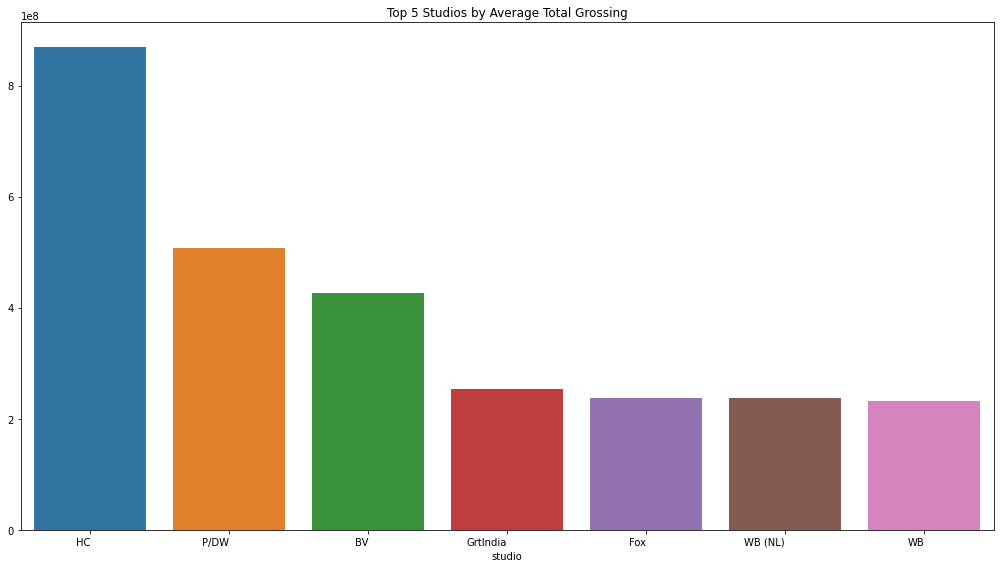

In [38]:
# use .groupby() to group studio and total_grossing
studio_gross_mean = df_clean.groupby('studio')['total_grossing'].mean().sort_values(ascending=False).head(7)

# Set plot size, type, title, xlabel, and ylabel
plt.figure(figsize=(14, 8))
sns.barplot(x=studio_gross_mean.index, y=studio_gross_mean.values)
plt.title('Top 5 Studios by Average Total Grossing')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

* Studios the company can collaborate with to boost Box Ofice grossings for its movies. 

## Recommendations

**1** The company's new movie studio should prioritize producing movies in the Adventure, Action, Animation, Fantasy, and Sci-Fi genres.

**2** The production team hired by the company must ensure the runtime for its movies ranges between 90 to 130 minutes. 

**3** The company can collaborate with HC, P/DW, BV , Grtindia, Fox and WB studios in the production of its movies to boost Box Office grossing. 

## Next Steps

* Conduct further exploration on how other predictor factors such as movie budgets, and featuring top-performing talent (actors & directors) influence Box-Office grossing.
* Examine whether a statistically significant correlation exists between a movie's grossing in the Box Office and the season (Summer, Spring, Fall, or Winter) a movie is released. 
* Conduct case studies on top-performing studios to comprehend evidence-based stragegies for success in the film production sector. 
